In [398]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

import folium

from folium import plugins

from folium.plugins import HeatMap

from folium.plugins import FastMarkerCluster

from folium.plugins import MarkerCluster
from sklearn.metrics import mean_squared_error 

In [399]:
# 파일불러오기, 데이터 변수 지정.

In [400]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

In [401]:
train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv') 

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

print()

In [402]:
# train 데이터 확인 

In [403]:
print(train.shape)

train.head(10)

(15035, 21)


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711
5,5,20150403T000000,662500.0,3,2.50,3560,9796,1.0,0,0,...,8,1860,1700,1965,0,98007,47.6007,-122.145,2210,8925
6,6,20140527T000000,468000.0,2,1.00,1160,6000,1.0,0,0,...,7,860,300,1942,0,98115,47.6900,-122.292,1330,6000
7,7,20140528T000000,310000.0,3,1.00,1430,19901,1.5,0,0,...,7,1430,0,1927,0,98028,47.7558,-122.229,1780,12697
8,8,20141007T000000,400000.0,3,1.75,1370,9680,1.0,0,0,...,7,1370,0,1977,0,98074,47.6127,-122.045,1370,10208
9,9,20150312T000000,530000.0,5,2.00,1810,4850,1.5,0,0,...,7,1810,0,1900,0,98107,47.6700,-122.394,1360,4850


In [404]:
# 변수(column) 정보 확인 

In [405]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             15035 non-null  int64  
 1   date           15035 non-null  object 
 2   price          15035 non-null  float64
 3   bedrooms       15035 non-null  int64  
 4   bathrooms      15035 non-null  float64
 5   sqft_living    15035 non-null  int64  
 6   sqft_lot       15035 non-null  int64  
 7   floors         15035 non-null  float64
 8   waterfront     15035 non-null  int64  
 9   view           15035 non-null  int64  
 10  condition      15035 non-null  int64  
 11  grade          15035 non-null  int64  
 12  sqft_above     15035 non-null  int64  
 13  sqft_basement  15035 non-null  int64  
 14  yr_built       15035 non-null  int64  
 15  yr_renovated   15035 non-null  int64  
 16  zipcode        15035 non-null  int64  
 17  lat            15035 non-null  float64
 18  long  

#  변수의 의미 

#. ID : 집을 구분하는 번호
#. date : 집을 구매한 날짜
#. price : 타겟 변수인 집의 가격
#. bedrooms : 침실의 수
#. bathrooms : 침실당 화장실 개수
#. sqft_living : 주거 공간의 평방 피트
#. sqft_lot : 부지의 평방 피트
#. floors : 집의 층수
#. waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
#. view : 집이 얼마나 좋아 보이는지의 정도
#. condition : 집의 전반적인 상태
#. grade : King County grading 시스템 기준으로 매긴 집의 등급
#. sqft_above : 지하실을 제외한 평방 피트
#. sqft_basement : 지하실의 평방 피트
#. yr_built : 집을 지은 년도
#. yr_renovated : 집을 재건축한 년도
#. zipcode : 우편번호
#. lat : 위도
#. long : 경도
#. sqft_living15 : 근처 15 가구의 주거 공간, 평방 피트
#. sqft_lot15 : 근처 15가구의 부지, 평방 피트


In [406]:
#결측치 확인 (데이터가ㅏ NaN값이면 True, 아니면 false로 출력)

In [407]:
print(train.isnull())
print(train.isnull().sum())

          id   date  price  bedrooms  bathrooms  sqft_living  sqft_lot  \
0      False  False  False     False      False        False     False   
1      False  False  False     False      False        False     False   
2      False  False  False     False      False        False     False   
3      False  False  False     False      False        False     False   
4      False  False  False     False      False        False     False   
...      ...    ...    ...       ...        ...          ...       ...   
15030  False  False  False     False      False        False     False   
15031  False  False  False     False      False        False     False   
15032  False  False  False     False      False        False     False   
15033  False  False  False     False      False        False     False   
15034  False  False  False     False      False        False     False   

       floors  waterfront   view  ...  grade  sqft_above  sqft_basement  \
0       False       False  False  ..

In [408]:
#결측치를 삭제또는 대체하기 (결측치는 없으나 그냥 써본 코드)

In [409]:
train.dropna()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15030,15030,20141014T000000,610685.0,4,2.50,2520,6023,2.0,0,0,...,9,2520,0,2014,0,98056,47.5137,-122.167,2520,6023
15031,15031,20150326T000000,1007500.0,4,3.50,3510,7200,2.0,0,0,...,9,2600,910,2009,0,98136,47.5537,-122.398,2050,6200
15032,15032,20140521T000000,360000.0,3,2.50,1530,1131,3.0,0,0,...,8,1530,0,2009,0,98103,47.6993,-122.346,1530,1509
15033,15033,20150223T000000,400000.0,4,2.50,2310,5813,2.0,0,0,...,8,2310,0,2014,0,98146,47.5107,-122.362,1830,7200


In [410]:
#집값 확인하기

In [411]:
train.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,15035.000000,1.503500e+04,15035.000000,15035.000000,15035.000000,1.503500e+04,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000
mean,7517.000000,5.406827e+05,3.369139,2.115065,2083.790223,1.529697e+04,1.498071,0.007117,0.234253,3.406651,7.660725,1794.158164,289.632059,1971.100432,83.798936,98078.031726,47.560721,-122.213677,1992.754772,12823.884935
std,4340.374984,3.715247e+05,0.902721,0.767519,922.134087,4.261282e+04,0.538522,0.084063,0.763376,0.646505,1.179803,831.738609,440.663284,29.407612,400.398498,53.297815,0.138164,0.141294,691.456442,27736.259787
min,0.000000,7.800000e+04,0.000000,0.000000,290.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,1.000000,290.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,3758.500000,3.220000e+05,3.000000,1.750000,1430.000000,5.027500e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,0.000000,1951.000000,0.000000,98033.000000,47.472700,-122.328000,1490.000000,5100.000000
50%,7517.000000,4.500000e+05,3.000000,2.250000,1910.000000,7.620000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1570.000000,0.000000,1975.000000,0.000000,98065.000000,47.571900,-122.231000,1850.000000,7610.000000
75%,11275.500000,6.450000e+05,4.000000,2.500000,2560.000000,1.069550e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2230.000000,550.000000,1997.000000,0.000000,98117.000000,47.678300,-122.126000,2360.000000,10076.000000
max,15034.000000,7.700000e+06,10.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4130.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


In [412]:
# 집값에 대한 씨본 박스플롯 출력

<AxesSubplot:xlabel='price'>

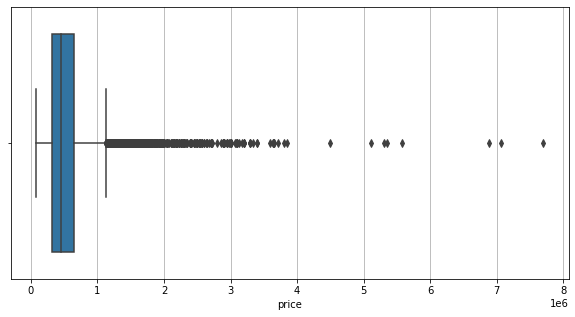

In [413]:
plt.rcParams["figure.figsize"] = (10,5)

plt.rcParams["axes.grid"] = True 

sns.boxplot(train['price'])

In [414]:
# 규제화 하기

<AxesSubplot:xlabel='price', ylabel='Density'>

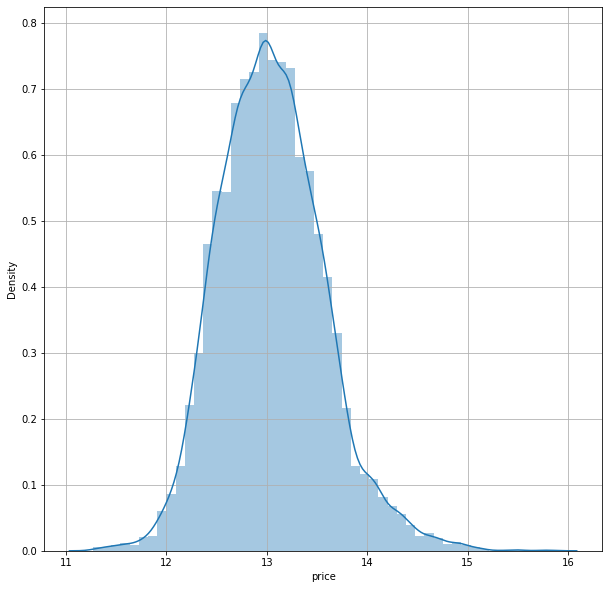

In [415]:
f, ax = plt.subplots(figsize=(10, 10))

sns.distplot(np.log1p(train['price']))

[CV] END .......................max_depth=1, n_estimators=50; total time=   0.1s
[CV] END ......................max_depth=1, n_estimators=100; total time=   0.2s
[CV] END ......................max_depth=10, n_estimators=50; total time=   0.4s
[CV] END ......................max_depth=10, n_estimators=50; total time=   0.4s
[CV] END .......................max_depth=1, n_estimators=50; total time=   0.1s
[CV] END ......................max_depth=1, n_estimators=100; total time=   0.2s
[CV] END ......................max_depth=10, n_estimators=50; total time=   0.4s
[CV] END ......................max_depth=10, n_estimators=50; total time=   0.4s
[CV] END .......................max_depth=1, n_estimators=50; total time=   0.1s
[CV] END ......................max_depth=1, n_estimators=100; total time=   0.2s
[CV] END ......................max_depth=10, n_estimators=50; total time=   0.4s
[CV] END .....................max_depth=10, n_estimators=100; total time=   0.5s
[CV] END ...................

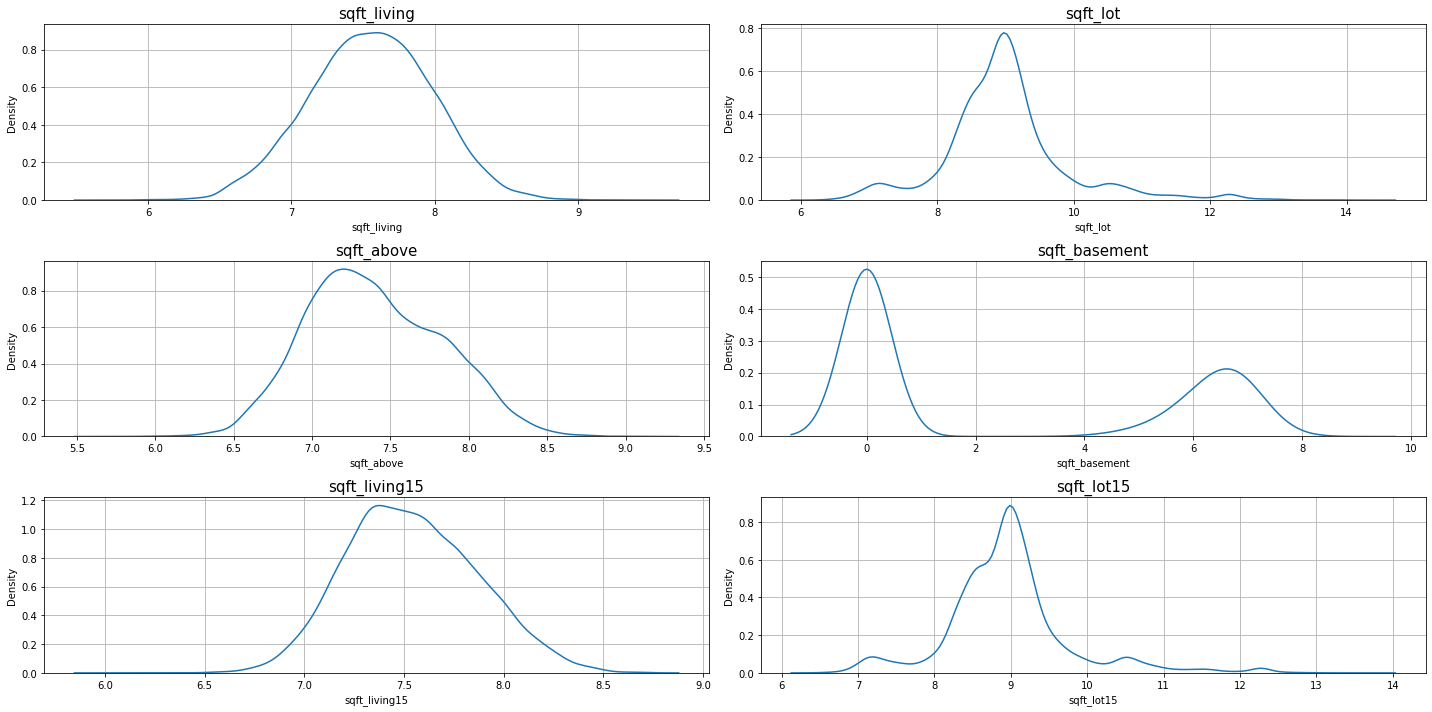

In [416]:
train_log = train.copy()
skew_columns = ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_lot15']

for c in skew_columns:
    train_log[c] = np.log1p(train_log[c].values)

fig, ax = plt.subplots(3, 2, figsize=(20, 10))

count = 0
for row in range(3):
    for col in range(2):
        sns.kdeplot(train_log[skew_columns[count]], ax=ax[row][col])
        ax[row][col].set_title(skew_columns[count], fontsize=15)
        count+=1
        
plt.tight_layout()

In [417]:
train_log['price'] = np.log1p(train['price'])
train_log

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,12.309987,3,1.00,7.074117,8.639588,1.0,0,0,...,7,7.074117,0.000000,1955,0,98178,47.5112,-122.257,7.201171,8.639588
1,1,20150225T000000,12.100718,2,1.00,6.647688,9.210440,1.0,0,0,...,6,6.647688,0.000000,1933,0,98028,47.7379,-122.233,7.908755,8.995041
2,2,20150218T000000,13.142168,3,2.00,7.427144,8.997271,1.0,0,0,...,8,7.427144,0.000000,1987,0,98074,47.6168,-122.045,7.496097,8.923191
3,3,20140627T000000,12.458779,3,2.25,7.447751,8.827615,2.0,0,0,...,7,7.447751,0.000000,1995,0,98003,47.3097,-122.327,7.713785,8.827615
4,4,20150115T000000,12.583999,3,1.50,6.966967,9.181118,1.0,0,0,...,7,6.966967,0.000000,1963,0,98198,47.4095,-122.315,7.409136,9.181118
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15030,15030,20141014T000000,13.322338,4,2.50,7.832411,8.703507,2.0,0,0,...,9,7.832411,0.000000,2014,0,98056,47.5137,-122.167,7.832411,8.703507
15031,15031,20150326T000000,13.822984,4,3.50,8.163656,8.881975,2.0,0,0,...,9,7.863651,6.814543,2009,0,98136,47.5537,-122.398,7.626083,8.732466
15032,15032,20140521T000000,12.793862,3,2.50,7.333676,7.031741,3.0,0,0,...,8,7.333676,0.000000,2009,0,98103,47.6993,-122.346,7.333676,7.319865
15033,15033,20150223T000000,12.899222,4,2.50,7.745436,8.668024,2.0,0,0,...,8,7.745436,0.000000,2014,0,98146,47.5107,-122.362,7.512618,8.881975


In [418]:
# 상관분석

In [419]:
train.corr()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
id,1.000000,0.020899,0.010520,0.104030,0.041725,-0.034077,0.182848,-0.011775,-0.024360,-0.101618,0.078622,0.073086,-0.050634,0.202477,-0.029810,-0.005761,0.002588,0.014757,0.029248,-0.032269
price,0.020899,1.000000,0.323672,0.525479,0.702899,0.096793,0.262588,0.265738,0.400806,0.039740,0.667211,0.608577,0.322218,0.047290,0.140808,-0.051498,0.301604,0.023547,0.586419,0.086384
bedrooms,0.010520,0.323672,1.000000,0.530548,0.596974,0.033475,0.189532,-0.004819,0.085703,0.034885,0.375286,0.494867,0.315183,0.158799,0.022729,-0.162081,-0.011190,0.135802,0.407394,0.027242
bathrooms,0.104030,0.525479,0.530548,1.000000,0.755853,0.089308,0.508649,0.075452,0.187488,-0.125907,0.666278,0.688255,0.282642,0.503964,0.065423,-0.207500,0.018110,0.227669,0.573541,0.088120
sqft_living,0.041725,0.702899,0.596974,0.755853,1.000000,0.176500,0.363193,0.108137,0.282821,-0.054213,0.762543,0.878736,0.434017,0.315927,0.064893,-0.200745,0.051609,0.245429,0.760271,0.184176
sqft_lot,-0.034077,0.096793,0.033475,0.089308,0.176500,1.000000,0.001535,0.025584,0.080441,-0.002099,0.119906,0.186242,0.017818,0.058686,-0.001451,-0.127709,-0.082234,0.227451,0.147562,0.728458
floors,0.182848,0.262588,0.189532,0.508649,0.363193,0.001535,1.000000,0.031159,0.034511,-0.261016,0.462598,0.529476,-0.239350,0.490436,0.009752,-0.059107,0.049004,0.126983,0.287125,-0.010287
waterfront,-0.011775,0.265738,-0.004819,0.075452,0.108137,0.025584,0.031159,1.000000,0.389669,0.011613,0.088061,0.081968,0.071576,-0.026523,0.104168,0.028632,-0.014772,-0.037922,0.091810,0.028255
view,-0.024360,0.400806,0.085703,0.187488,0.282821,0.080441,0.034511,0.389669,1.000000,0.045255,0.247924,0.172693,0.265880,-0.061670,0.107605,0.089247,0.005285,-0.073151,0.278267,0.076501
condition,-0.101618,0.039740,0.034885,-0.125907,-0.054213,-0.002099,-0.261016,0.011613,0.045255,1.000000,-0.143599,-0.152856,0.175064,-0.366590,-0.062342,0.001106,-0.015974,-0.110742,-0.091407,-0.003873


In [420]:
# 상관분석 히트맵 

<AxesSubplot:>

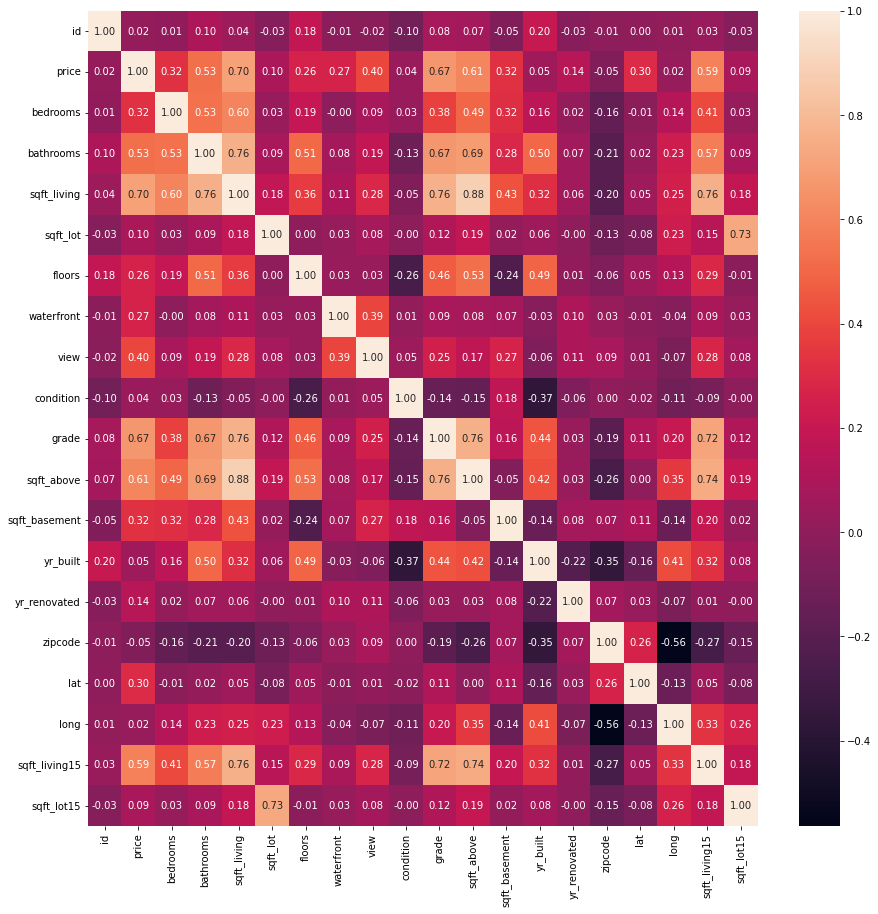

In [421]:
plt.figure(figsize=(15,15))
sns.heatmap(data = train.corr(), annot=True, 
fmt = '.2f')

상관계수
두 변수가 함께 변하는 정도를 -1~1 범위의 수치로 나타낸 것
단위로 인한 공분산의 차이를 어느 정도 보완해 줌
일반적으로 칼 피어슨이 개발한 피어슨 상관계수를 사용함
numpy의 corrcoef 함수를 사용함
상관계수 범위에 따른 상관정도 해석
-1.0 ~ -0.7: 매우 강한 음의 상관관계 있음
-0.7 ~ -0.3: 강한 음의 상관관계 있음
-0.3 ~ -0.1: 약한 음의 상관관계 있음
-0.1 ~ 0.1: 상관관계 없음
0.3 ~ 0.1: 약한 양의 상관관계 있음
0.7 ~ 0.3: 강한 양의 상관관계 있음
1.0 ~ 0.7: 매우 강한 양의 상관관계 있음

In [422]:
# 잡값과 상관 관계가 높은 것들

# 1. Grade 0.70 (매우강한양의 상관관계)
# 2. sqft_living 0.69 (강한 양의 상관관계)
# 3. sqft_above 0.60 (강한 양의 상관관계)
# 4. bedroom 0.50 (강한 양의 상관관계)
# 5. lat 0.45 (강한 양의 상관관계)
# 6. View 0.34 (강한 양의 상관관계)
# 7. floors 0.32 (강한 양의 상관관계)

In [423]:
train_raw=train.copy()

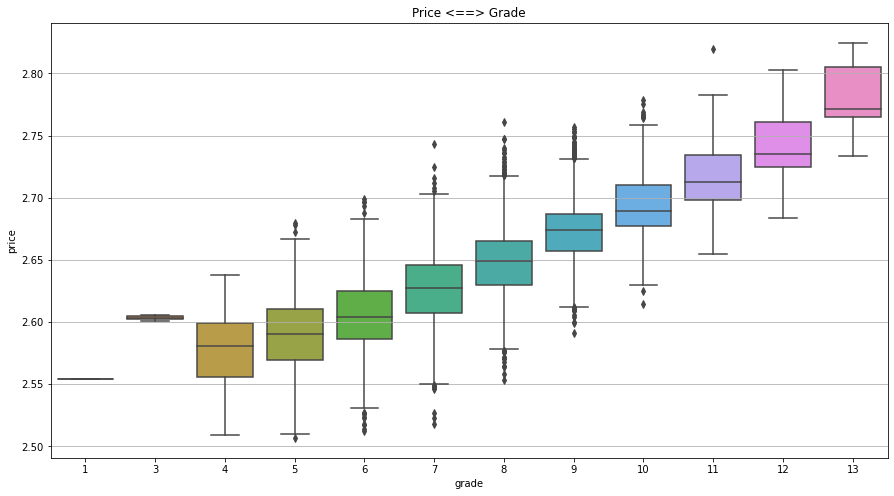

In [424]:
#집값과 등급의 상관 관계 

train_data = pd.concat([train['price'], train['grade']], axis=1)
f, ax = plt.subplots(figsize=(15, 8))
plt.title("Price <==> Grade")
fig = sns.boxplot(x="grade", y="price", data=raw_train)

# Grade가 높을 수록 집값을 오른 것을 확인할 수 있다. 

In [425]:
# 날짜 변수 만들기 

In [426]:
train['date'] = train['date'].apply(lambda i: i[:6]).astype(int)
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,201410,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,201502,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,201502,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,201406,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,201501,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [427]:
y = train['price']
print(train.columns)

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [428]:
y

0         221900.0
1         180000.0
2         510000.0
3         257500.0
4         291850.0
           ...    
15030     610685.0
15031    1007500.0
15032     360000.0
15033     400000.0
15034     325000.0
Name: price, Length: 15035, dtype: float64

In [429]:
y = np.log1p(y)
y

0        12.309987
1        12.100718
2        13.142168
3        12.458779
4        12.583999
           ...    
15030    13.322338
15031    13.822984
15032    12.793862
15033    12.899222
15034    12.691584
Name: price, Length: 15035, dtype: float64

In [430]:
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

In [431]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

In [432]:
random_state=2020       
gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

In [433]:
gboost.__class__.__name__

'GradientBoostingRegressor'

In [434]:
df = {}

for model in models:
    # 모델 이름 획득
    model_name = model.__class__.__name__

    # train, test 데이터셋 분리 - 여기에도 random_state를 고정합니다. 
    X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)

    # 모델 학습
    model.fit(X_train, y_train)
    
    # 예측
    y_pred = model.predict(X_test)

    # 예측 결과의 rmse값 저장
    df[model_name] = rmse(y_test, y_pred)
    
    # data frame에 저장
    score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
    
df

{'GradientBoostingRegressor': 5207.713870266944,
 'XGBRegressor': 4088.336236928974,
 'LGBMRegressor': 15433.175244744862,
 'RandomForestRegressor': 2511.824770913762}

In [435]:
def get_scores(models, train, y):
    df = {}
    
    for model in models:
        model_name = model.__class__.__name__
        
        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        df[model_name] = rmse(y_test, y_pred)
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
            
    return score_df

In [436]:
from sklearn.model_selection import GridSearchCV

In [437]:
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [1, 10],
}

In [438]:
model = LGBMRegressor(random_state=random_state)

In [439]:
grid_model = GridSearchCV(model, param_grid=param_grid, \
                        scoring='neg_mean_squared_error', \
                        cv=5, verbose=1, n_jobs=5)

grid_model.fit(train, y)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(cv=5, estimator=LGBMRegressor(random_state=2020), n_jobs=5,
             param_grid={'max_depth': [1, 10], 'n_estimators': [50, 100]},
             scoring='neg_mean_squared_error', verbose=1)

In [440]:
grid_model.cv_results_

{'mean_fit_time': array([0.14607587, 0.27360907, 0.57363391, 0.54631348]),
 'std_fit_time': array([0.01099028, 0.08285676, 0.120621  , 0.08318179]),
 'mean_score_time': array([0.00722227, 0.02468338, 0.01916714, 0.02053146]),
 'std_score_time': array([0.00029788, 0.01352496, 0.00847567, 0.00314788]),
 'param_max_depth': masked_array(data=[1, 1, 10, 10],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_n_estimators': masked_array(data=[50, 100, 50, 100],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'max_depth': 1, 'n_estimators': 50},
  {'max_depth': 1, 'n_estimators': 100},
  {'max_depth': 10, 'n_estimators': 50},
  {'max_depth': 10, 'n_estimators': 100}],
 'split0_test_score': array([-0.00815506, -0.00137909, -0.00039503, -0.00033392]),
 'split1_test_score': array([-0.00747376, -0.00102995, -0.00028429, -0.00026307]),
 'split2_test_score': array([-0.00630999

In [441]:
params = grid_model.cv_results_['params']
params

[{'max_depth': 1, 'n_estimators': 50},
 {'max_depth': 1, 'n_estimators': 100},
 {'max_depth': 10, 'n_estimators': 50},
 {'max_depth': 10, 'n_estimators': 100}]

In [442]:
score = grid_model.cv_results_['mean_test_score']
score

array([-0.00692972, -0.00094106, -0.00024923, -0.00023417])

In [443]:
results = pd.DataFrame(params)
results['score'] = score

results

,max_depth,n_estimators,score
0,1,50,-0.006930
1,1,100,-0.000941
2,10,50,-0.000249
3,10,100,-0.000234


In [444]:
results['RMSE'] = np.sqrt(-1 * results['score'])
results

,max_depth,n_estimators,score,RMSE
0,1,50,-0.006930,0.083245
1,1,100,-0.000941,0.030677
2,10,50,-0.000249,0.015787
3,10,100,-0.000234,0.015303


In [445]:
results = results.rename(columns={'RMSE': 'RMSLE'})
results

,max_depth,n_estimators,score,RMSLE
0,1,50,-0.006930,0.083245
1,1,100,-0.000941,0.030677
2,10,50,-0.000249,0.015787
3,10,100,-0.000234,0.015303


In [446]:
results = results.sort_values('RMSLE')
results

,max_depth,n_estimators,score,RMSLE
3,10,100,-0.000234,0.015303
2,10,50,-0.000249,0.015787
1,1,100,-0.000941,0.030677
0,1,50,-0.006930,0.083245


In [447]:
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                              cv=5, verbose=verbose, n_jobs=n_jobs)
    
    # 모델 fitting
    grid_model.fit(train, y)

    # 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
    
    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score
    
    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results

In [448]:
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [1, 10],
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


,max_depth,n_estimators,score,RMSLE
3,10,100,-0.000234,0.015303
2,10,50,-0.000249,0.015787
1,1,100,-0.000941,0.030677
0,1,50,-0.006930,0.083245


In [449]:
model = LGBMRegressor(max_depth=5, n_estimators=100, random_state=random_state)
model.fit(train, y)
prediction = model.predict(train)
prediction

array([12.32114419, 12.08707764, 13.14012206, ..., 12.79396088,
       12.89931534, 12.69253584])

In [450]:
prediction = np.expm1(prediction)
prediction

array([224389.74008385, 177561.44754448, 508957.65431116, ...,
       360035.56813454, 400037.20605296, 325309.64606618])

In [451]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission.head()

,id,price
0,15035,100000
1,15036,100000
2,15037,100000
3,15038,100000
4,15039,100000


In [461]:
submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, 'lgbm', '0.164399')
submission.to_csv(submission_csv_path, index=False)
print(submission_csv_path)

/aiffel/aiffel/kaggle_kakr_housing/data/submission_lgbm_RMSLE_0.164399.csv


In [462]:
def save_submission(model, train, y, test, model_name, rmsle=None):
    model.fit(train, y)
    prediction = model.predict(test)
    prediction = np.expm1(prediction)
    data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    submission['price'] = prediction
    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))

[CV] END .......................max_depth=1, n_estimators=50; total time=   0.1s
[CV] END ......................max_depth=1, n_estimators=100; total time=   0.2s
[CV] END ......................max_depth=10, n_estimators=50; total time=   0.4s
[CV] END ......................max_depth=10, n_estimators=50; total time=   0.4s
[CV] END .......................max_depth=1, n_estimators=50; total time=   0.1s
[CV] END ......................max_depth=1, n_estimators=100; total time=   0.2s
[CV] END ......................max_depth=10, n_estimators=50; total time=   0.4s
[CV] END ......................max_depth=10, n_estimators=50; total time=   0.4s
[CV] END .......................max_depth=1, n_estimators=50; total time=   0.2s
[CV] END ......................max_depth=1, n_estimators=100; total time=   0.2s
[CV] END ......................max_depth=10, n_estimators=50; total time=   0.4s
[CV] END .....................max_depth=10, n_estimators=100; total time=   0.4s
[CV] END ...................

In [ ]:
#  회고록

# 스터디 때 배운 상관 분석을 이용해서 집값과 변수의 상관관계를 그래프를 통해 확인하였다. 

# 모델링 튜닝은 아직 많이 어려웠다  공부를 더 해야겠다. 

#score120140.31249